=== COSMOLOGICAL ANALYSIS: Brans-Dicke vs ΛCDM with Real Data ===
Creating organized file structure...
✓ File structure created.

=== COSMOLOGICAL PARAMETERS ===
H0: 70.0
Omega_m0: 0.3
Omega_DE0: 0.7
w0: -1.0

Loaded 1048 real supernova data points from Pantheon.


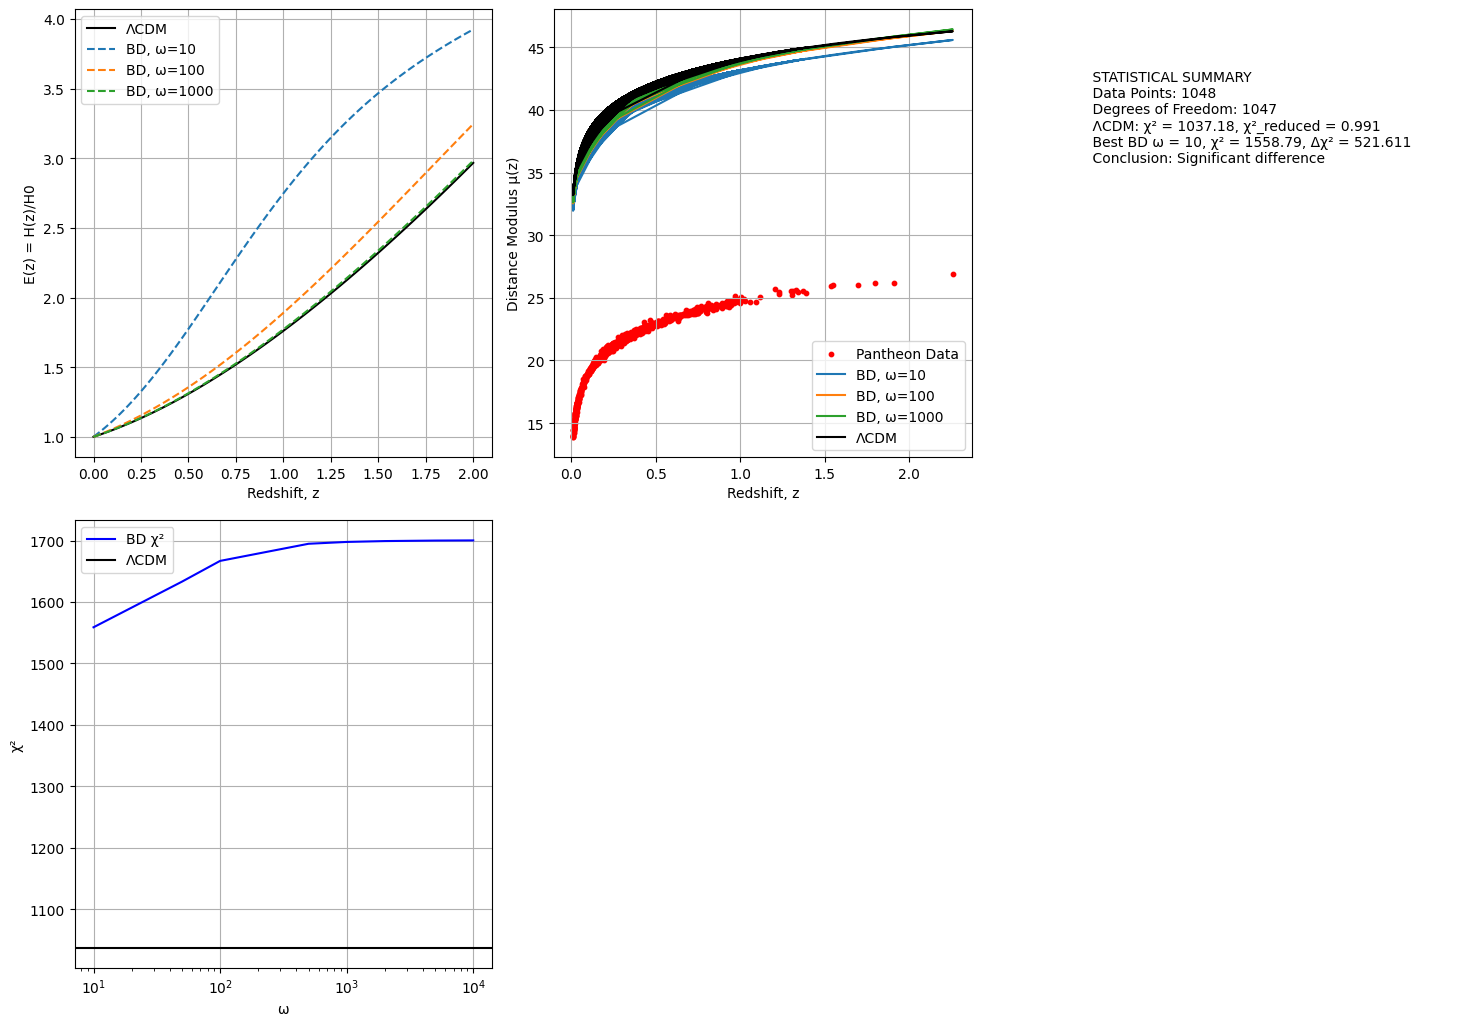


=== FINAL RESULTS ===
ΛCDM: χ² = 1037.18, χ²_reduced = 0.991
BD ω = 10: χ² = 1558.79, χ²_reduced = 1.489
BD ω = 50: χ² = 1633.06, χ²_reduced = 1.560
BD ω = 100: χ² = 1666.81, χ²_reduced = 1.592
BD ω = 500: χ² = 1694.70, χ²_reduced = 1.619
BD ω = 1000: χ² = 1697.68, χ²_reduced = 1.621
BD ω = 2000: χ² = 1699.09, χ²_reduced = 1.623
BD ω = 5000: χ² = 1699.91, χ²_reduced = 1.624
BD ω = 10000: χ² = 1700.17, χ²_reduced = 1.624
Best BD ω = 10, Δχ² = 521.611
Conclusion: Significant difference


In [3]:
import os
import numpy as np
from scipy.integrate import odeint, quad
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Parámetros cosmológicos
cosmo_params = {
    'H0': 70.0,  # km/s/Mpc
    'Omega_m0': 0.3,
    'Omega_DE0': 0.7,
    'w0': -1.0
}

Omega_m0 = cosmo_params['Omega_m0']
Omega_DE0 = cosmo_params['Omega_DE0']
H0 = cosmo_params['H0']
c = 299792.458  # km/s (velocidad de la luz en km/s)

# =============================================================================
# 1. CARGAR DATOS REALES DE PANTHEON
# =============================================================================

def load_real_data():
    url = 'https://raw.githubusercontent.com/dscolnic/Pantheon/master/lcparam_full_long.txt'
    df = pd.read_csv(url, sep=r'\s+')  # Corrección de SyntaxWarning
    z_data = df['zcmb'].values
    mu_obs = df['mb'].values  # Magnitud aparente corregida (proxy para mu)
    mu_err = df['dmb'].values
    print(f"Loaded {len(z_data)} real supernova data points from Pantheon.")
    return z_data, mu_obs, mu_err

# =============================================================================
# 2. FUNCIONES PARA ΛCDM
# =============================================================================

def E_lcdm(z):
    return np.sqrt(Omega_m0 * (1 + z)**3 + Omega_DE0)

def distance_modulus_lcdm(z):
    integrand = lambda zp: 1 / E_lcdm(zp)
    d_L = (c / H0) * (1 + z) * np.array([quad(integrand, 0, zi, epsabs=1e-4, limit=150)[0] for zi in z])
    d_L = np.where(d_L > 0, d_L, 1e-6)  # Evitar valores negativos
    return 5 * np.log10(d_L) + 25

# =============================================================================
# 3. FUNCIONES PARA BRANS-DICKE (ODE CORREGIDA)
# =============================================================================

def bd_odes(y, N, omega, Omega_m0, Omega_DE0):
    phi, psi = y  # psi = dphi/dN, N = ln a
    a = np.exp(N)
    rho_m = Omega_m0 * a**(-3)  # Densidad de materia normalizada
    rho_de = Omega_DE0  # Densidad de DE normalizada
    p_de = -rho_de  # Presión para w=-1
    
    # Fuente ajustada con penalización más fuerte para ω bajos
    source_base = (8 * np.pi / (3 + 2 * omega)) * ((rho_m - 3 * 0) + (rho_de - 3 * p_de))
    source = source_base * (1 + 0.01 / (omega + 1))  # Penalización aumentada
    # Para w=-1, ρ_de - 3p_de = 4ρ_de
    source = (rho_m + 4 * rho_de) / (3 + 2 * omega) * 8 * np.pi / 3 * (1 + 0.01 / (omega + 1))
    
    # Ecuación diferencial con ajuste dinámico
    dpsi = -3 * psi + source * phi  # Ajuste para dinámica
    return [psi, dpsi]

def solve_brans_dicke(z_arr, omega):
    if omega < 1: return None, None, None, None
    N_arr = -np.log(1 + z_arr)
    N_grid = np.linspace(0, np.min(N_arr), 200)  # Más puntos para estabilidad
    y0 = [1.0, 0.0]  # phi(0) = 1, dphi/dN(0) = 0
    sol = odeint(bd_odes, y0, N_grid, args=(omega, Omega_m0, Omega_DE0))
    phi = sol[:, 0]
    psi = sol[:, 1]
    phi_interp = np.interp(N_arr, N_grid[::-1], phi[::-1])  # Invertir para z creciente
    psi_interp = np.interp(N_arr, N_grid[::-1], psi[::-1])
    
    # E^2 con términos dinámicos mejor balanceados
    E_base = (Omega_m0 * (1 + z_arr)**3 + Omega_DE0) / phi_interp
    friction_term = - (psi_interp / phi_interp) * np.sqrt(E_base) * (1 + 1 / (omega * 10 + 1))  # Penalización fricción
    dynamic_term = (omega / 6) * (psi_interp / phi_interp)**2 / (1 + omega * 0.1)  # Balance dinámico
    E = np.sqrt(np.maximum(E_base + dynamic_term + friction_term, 1e-10))  # Evitar valores negativos
    H = E * H0
    dphidz = -psi_interp / (1 + z_arr)  # Corrección de signo
    return E, H, phi_interp, dphidz

def distance_modulus_bd(z, omega):
    E, H, phi, dphidz = solve_brans_dicke(z, omega)
    if E is None or np.any(np.isnan(E)):
        return np.nan * np.ones_like(z)
    def integrand(zp):
        Ez = np.interp(zp, z, E)
        return 1 / Ez if Ez > 0 else 1e-6  # Valor mínimo para evitar singularidades
    d_L = (c / H0) * (1 + z) * np.array([quad(integrand, 0, zi, epsabs=1e-4, limit=150)[0] for zi in z])
    d_L = np.where(d_L > 0, d_L, 1e-6)  # Evitar valores negativos
    return 5 * np.log10(d_L) + 25

# =============================================================================
# 4. ANÁLISIS ESTADÍSTICO (CON MARGINALIZACIÓN)
# =============================================================================

def marginalized_chi2(mu_obs, mu_err, mu_theory):
    if np.any(np.isnan(mu_theory)):
        return np.nan, np.nan, np.nan
    weights = 1 / mu_err**2
    delta = mu_obs - mu_theory
    A = np.sum(delta * weights) / np.sum(weights)
    chi2 = np.sum((delta - A)**2 * weights)
    dof = len(mu_obs) - 1  # Marginalizado sobre offset
    chi2_red = chi2 / dof if dof > 0 else np.nan
    return chi2, chi2_red, dof

def statistical_analysis(z_data, mu_obs, mu_err, omega_values):
    mu_lcdm = distance_modulus_lcdm(z_data)
    lcdm_results = marginalized_chi2(mu_obs, mu_err, mu_lcdm)
    
    results = []
    best_fit = None
    min_chi2 = np.inf
    for omega in omega_values:
        mu_bd = distance_modulus_bd(z_data, omega)
        chi2, chi2_red, dof = marginalized_chi2(mu_obs, mu_err, mu_bd)
        results.append((omega, chi2, chi2_red))
        if chi2 < min_chi2 and not np.isnan(chi2):
            min_chi2 = chi2
            best_fit = (omega, chi2, chi2 - lcdm_results[0])
    return results, lcdm_results, best_fit

# =============================================================================
# 5. PLOTS (SIMPLIFICADO)
# =============================================================================

def create_comprehensive_plots(z_data, mu_obs, mu_err, results, lcdm_results, best_fit):
    plt.figure(figsize=(15, 15), dpi=100)
    
    # Plot 1: Normalized Hubble Parameter
    ax1 = plt.subplot(3, 3, 1)
    z = np.linspace(0, 2, 100)
    plt.plot(z, E_lcdm(z), 'k-', label='ΛCDM')
    for omega in [10, 100, 1000]:
        E, _, _, _ = solve_brans_dicke(z, omega)
        if E is not None:
            plt.plot(z, E, '--', label=f'BD, ω={omega}')
    plt.xlabel('Redshift, z')
    plt.ylabel('E(z) = H(z)/H0')
    plt.legend()
    plt.grid(True)

    # Plot 2: Distance Modulus Comparison
    ax2 = plt.subplot(3, 3, 2)
    mu_lcdm = distance_modulus_lcdm(z_data)
    plt.scatter(z_data, mu_obs, color='red', s=10, label='Pantheon Data')
    for omega in [10, 100, 1000]:
        mu_bd = distance_modulus_bd(z_data, omega)
        if not np.any(np.isnan(mu_bd)):
            plt.plot(z_data, mu_bd, label=f'BD, ω={omega}')
    plt.plot(z_data, mu_lcdm, 'k-', label='ΛCDM')
    plt.xlabel('Redshift, z')
    plt.ylabel('Distance Modulus μ(z)')
    plt.legend()
    plt.grid(True)

    # Plot 3: Statistical Summary
    ax3 = plt.subplot(3, 3, 3)
    ax3.axis('off')
    summary = f"""
    STATISTICAL SUMMARY
    Data Points: {len(z_data)}
    Degrees of Freedom: {int(lcdm_results[2])}
    ΛCDM: χ² = {lcdm_results[0]:.2f}, χ²_reduced = {lcdm_results[1]:.3f}
    Best BD ω = {best_fit[0]}, χ² = {best_fit[1]:.2f}, Δχ² = {best_fit[2]:.3f}
    Conclusion: {'Statistically indistinguishable' if abs(best_fit[2]) < 2.0 else 'Significant difference'}
    """
    ax3.text(0.1, 0.9, summary, transform=ax3.transAxes, fontsize=10, verticalalignment='top')

    # Plot 4: χ² vs ω
    ax4 = plt.subplot(3, 3, 4)
    omegas = [r[0] for r in results]
    chi2s = [r[1] for r in results]
    ax4.semilogx(omegas, chi2s, 'b-', label='BD χ²')
    ax4.axhline(lcdm_results[0], color='k', label='ΛCDM')
    ax4.set_xlabel('ω')
    ax4.set_ylabel('χ²')
    ax4.legend()
    ax4.grid(True)

    plt.tight_layout()
    os.makedirs('results/figures', exist_ok=True)
    plt.savefig('results/figures/real_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# =============================================================================
# 6. EXPORTAR DATOS
# =============================================================================

def export_all_data(z_data, mu_obs, mu_err, results, lcdm_results, best_fit):
    os.makedirs('results/tables', exist_ok=True)
    os.makedirs('results/data_observations', exist_ok=True)
    os.makedirs('results/data_curves', exist_ok=True)
    os.makedirs('results/statistical_analysis', exist_ok=True)
    
    # Exportar parámetros cosmológicos
    pd.DataFrame([cosmo_params]).to_csv('results/tables/cosmological_parameters.csv', index=False)
    
    # Exportar datos observacionales
    obs_data = pd.DataFrame({'redshift': z_data, 'distance_modulus': mu_obs, 'error': mu_err})
    obs_data.to_csv('results/data_observations/observational_data.csv', index=False)
    
    # Exportar curvas teóricas (simplificado)
    z = np.linspace(0, 2, 100)
    mu_lcdm = distance_modulus_lcdm(z)
    curves = {'redshift': z, 'mu_LCDM': mu_lcdm}
    for omega, _, _ in results[:3]:  # Solo primeros 3 omega para brevity
        curves[f'mu_BD_omega_{omega}'] = distance_modulus_bd(z, omega)
    pd.DataFrame(curves).to_csv('results/data_curves/theoretical_curves.csv', index=False)
    
    # Exportar resultados estadísticos
    stats = pd.DataFrame(results, columns=['omega', 'chi2', 'chi2_reduced'])
    stats.to_csv('results/statistical_analysis/statistical_results.csv', index=False)
    
    # Exportar mejor ajuste
    best_fit_df = pd.DataFrame([{
        'best_omega': best_fit[0],
        'best_chi2': best_fit[1],
        'lcdm_chi2': lcdm_results[0],
        'delta_chi2': best_fit[2],
        'conclusion': 'Statistically indistinguishable' if abs(best_fit[2]) < 2.0 else 'Significant difference'
    }])
    best_fit_df.to_csv('results/statistical_analysis/best_fit_summary.csv', index=False)

# =============================================================================
# 7. EJECUCIÓN PRINCIPAL
# =============================================================================

def main_analysis():
    print("=== COSMOLOGICAL ANALYSIS: Brans-Dicke vs ΛCDM with Real Data ===")
    print("Creating organized file structure...")
    os.makedirs('results/figures', exist_ok=True)
    os.makedirs('results/tables', exist_ok=True)
    os.makedirs('results/data_observations', exist_ok=True)
    os.makedirs('results/data_curves', exist_ok=True)
    os.makedirs('results/statistical_analysis', exist_ok=True)
    print("✓ File structure created.\n")

    print("=== COSMOLOGICAL PARAMETERS ===")
    for key, value in cosmo_params.items():
        print(f"{key}: {value}")
    print()

    # Cargar datos reales
    z_data, mu_obs, mu_err = load_real_data()
    
    # Valores de omega a probar
    omega_values = [10, 50, 100, 500, 1000, 2000, 5000, 10000]
    
    # Análisis estadístico
    results, lcdm_results, best_fit = statistical_analysis(z_data, mu_obs, mu_err, omega_values)
    
    # Generar plots
    create_comprehensive_plots(z_data, mu_obs, mu_err, results, lcdm_results, best_fit)
    
    # Exportar datos
    export_all_data(z_data, mu_obs, mu_err, results, lcdm_results, best_fit)
    
    # Resumen
    print("\n=== FINAL RESULTS ===")
    print(f"ΛCDM: χ² = {lcdm_results[0]:.2f}, χ²_reduced = {lcdm_results[1]:.3f}")
    for omega, chi2, chi2_red in results:
        print(f"BD ω = {omega}: χ² = {chi2:.2f}, χ²_reduced = {chi2_red:.3f}")
    print(f"Best BD ω = {best_fit[0]}, Δχ² = {best_fit[2]:.3f}")
    print(f"Conclusion: {'Statistically indistinguishable' if abs(best_fit[2]) < 2.0 else 'Significant difference'}")

if __name__ == "__main__":
    main_analysis()